### Imports

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from skimage.feature import hog
from skimage import exposure
from sklearn.datasets import fetch_openml
from matplotlib import pyplot as plt

### Load MNIST dataset using scikit-learn

In [2]:
mnist = fetch_openml('mnist_784',parser='auto')

### Helping Functions

In [3]:

def compute_hog_features(image):
    feature_descriptor, hog_image = hog(image, orientations=10, pixels_per_cell=(4,4), cells_per_block=(1,1), visualize=True)
    rescaled = exposure.rescale_intensity(hog_image, in_range=(0,64))
    return feature_descriptor, rescaled

### Splitting Data

In [4]:

# Extract features (images) and labels
images, labels = mnist.data, mnist.target.astype(np.uint8)

# Split data to train(80%) and test
train_images, test_images, train_labels, test_labels = train_test_split(np.array(images), np.array(labels), test_size=0.2, random_state=42)
train_images, test_images, train_labels, test_labels = train_test_split(test_images, test_labels, test_size=0.2, random_state=42)

### Another method using tensorflow
# from tensorflow.keras import datasets
# (train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()

# Display number of samples for train and test
print(len(train_images), len(test_images))


11200 2800


### Data Preprocessing

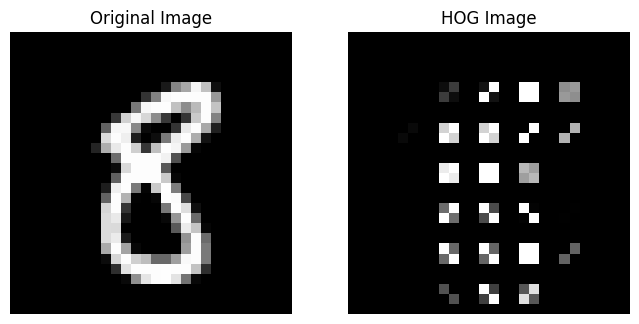

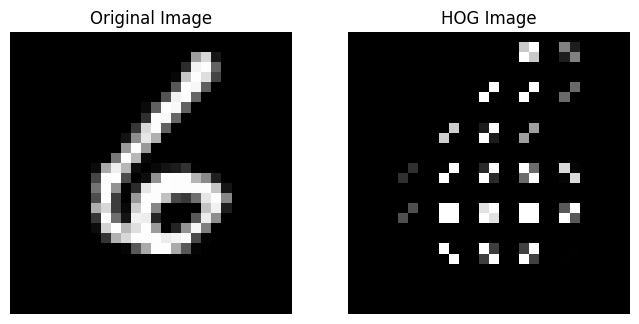

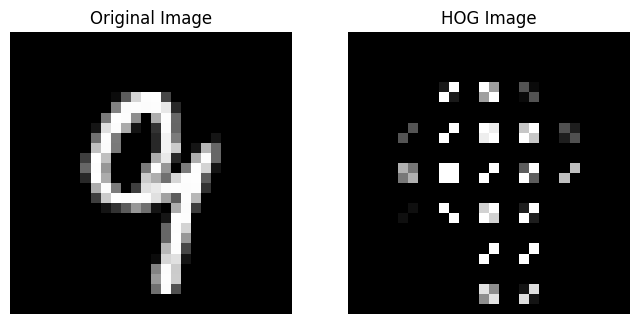

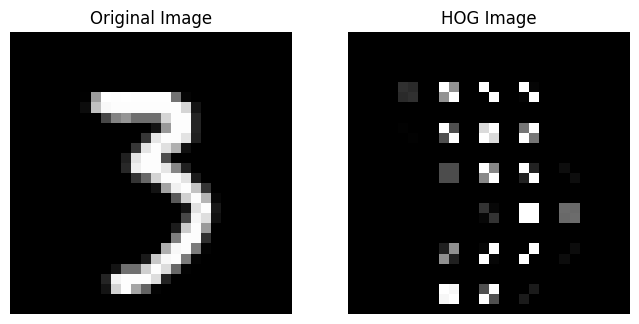

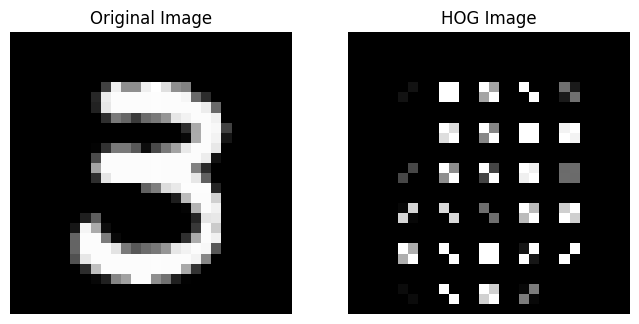

In [5]:
# Take the first 5 images for example and print them before and after HOG
for i in range(5):
    # Take example image as current i index
    example_image = train_images[i].reshape(28,28)

    # Compute HOG features for the example image
    ft, hog_example_image = compute_hog_features(example_image)

    # Plot the original and HOG images side by side
    plt.figure(figsize=(8, 4))

    # # Plot Original image
    plt.subplot(1, 2, 1)
    plt.imshow(example_image, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    # Plot hog version of image
    plt.subplot(1, 2, 2)
    plt.imshow(hog_example_image, cmap='gray')
    plt.title('HOG Image')
    plt.axis('off')

    plt.show()

In [6]:
# Run the HOG feature extraction function on the data set
hog_X_train_descriptors, hog_X_train_images = zip(*[compute_hog_features(image.reshape(28, 28)) for image in train_images])
hog_X_train_images = np.array(hog_X_train_images)
hog_X_train_descriptors = np.array(hog_X_train_descriptors)

hog_X_test_descriptors, hog_X_test_images = zip(*[compute_hog_features(image.reshape(28, 28)) for image in test_images])
hog_X_test_images = np.array(hog_X_test_images)
hog_X_test_descriptors = np.array(hog_X_test_descriptors)

# Print length of both the training and test sets
print(len(hog_X_train_images), len(hog_X_test_images))

11200 2800


### Models

In [7]:
import sklearn.svm
from sklearn.multiclass import OneVsOneClassifier
from sklearn.metrics import accuracy_score

# Create an instance of the sklearn.svm.OneVsOneClassifier class.
classifier = OneVsOneClassifier(estimator=sklearn.svm.LinearSVC(max_iter=2000))
hog_X_train_images = hog_X_train_images.reshape((11200, -1))
hog_X_test_images = hog_X_test_images.reshape((2800, -1))
# Fit the classifier to the training data.
classifier.fit(hog_X_train_images, train_labels)

# Make predictions on the test data.
y_pred1 = classifier.predict(hog_X_test_images)

# Evaluate the model.
accuracy = accuracy_score(test_labels, y_pred1)
print("Accuracy:", accuracy)

Accuracy: 0.9317857142857143


In [8]:
# KNN
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 4)

# Fit the model
knn.fit(hog_X_train_descriptors, train_labels)

# Make predictions in the test dataset
y_pred2 = knn.predict(hog_X_test_descriptors)

# Print accuracy
acc = accuracy_score(test_labels , y_pred2)
print("Accuracy: ", acc)

Accuracy:  0.945


In [9]:
#Logistic Regression

# import modules
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

In [10]:
# training on default settings/hyper parameters
logistic_classifier = LogisticRegression()
logistic_classifier.fit(hog_X_train_descriptors, train_labels)
logistic_y_pred = logistic_classifier.predict(hog_X_test_descriptors)

default_accuracy = accuracy_score(test_labels, logistic_y_pred)
default_f1 = f1_score(test_labels, logistic_y_pred, average='weighted')

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [11]:
print(f'Accuracy on default Settings: {default_accuracy}')
print(f'F1-score on default Settings: {default_f1}')

Accuracy on default Settings: 0.9685714285714285
F1-score on default Settings: 0.968555189600702


Possible Solvers/Optimizers are [‘lbfgs’, ‘liblinear’, ‘newton-cg’, ‘newton-cholesky’, ‘sag’, ‘saga’]

but we will only use newton-cholesky, sag, saga, lbfgs
since we have a multiclass classification

and for C parameter this is the inverse of lamda in regularization
it controls how strict our regularization is

as C gets shrinks the regularization effect gets smaller and vice versa.
for really small C values:
the regularization is almost not there, it is more in danger to suffer from ovefitting

sometimes reasonable small C values affect the model nicely

In [12]:
# ‘lbfgs’, ‘liblinear’, ‘newton-cg’, ‘newton-cholesky’, ‘sag’, ‘saga’
# newton-cg, sag, saga, lbfgs
solvers = ['newton-cg', 'sag', 'saga', 'lbfgs']

# For me: None is deprecated
# penalties = ['l2']

# C controls how strict regularization is (lamda inverse) 1 / 2C
lambdas = [10000, 1000, 100, 10, 1, 0.1, 0.01, 0.001]

# fit_intercept adds bias or not
# fit_intercept = [True, False]


# grid = dict(solver=solvers,penalty=penalties,C=C, fit_intercept=fit_intercept)
# grid_search = GridSearchCV(estimator=logistic_classifier, param_grid=grid, n_jobs=-1, scoring='accuracy',error_score=0)
# grid_result = grid_search.fit(hog_X_train_descriptors, train_labels)

# grid_result.best_params_

In [13]:
# store a record for each possibility (accuracy, optimizer, Cvalue)
params = []

# to store best params that gets highest accurcay
best_accuracy: float = 0
best_solver: str = ''
best_lamda_inverse: float = 0

# try all possibilities
for solver in solvers:
    for lam in lambdas:
        logistic_classifier = LogisticRegression(solver=solver, C=lam)
        logistic_classifier.fit(hog_X_train_descriptors, train_labels)
        y_pred = logistic_classifier.predict(hog_X_test_descriptors)

        curr_accuracy = accuracy_score(test_labels, y_pred)
        curr_f1 = f1_score(test_labels, y_pred, average='weighted')
        if curr_accuracy > best_accuracy:
            best_accuracy = curr_accuracy
            best_solver = solver
            best_lamda_inverse = lam

        params.append([curr_accuracy, solver, lam, curr_f1])

print(params)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

[[0.9592857142857143, 'newton-cg', 10000, 0.9592269410806412], [0.9589285714285715, 'newton-cg', 1000, 0.958875384002574], [0.9621428571428572, 'newton-cg', 100, 0.9620863803270475], [0.9628571428571429, 'newton-cg', 10, 0.9628084790453995], [0.9678571428571429, 'newton-cg', 1, 0.9678439761333506], [0.9657142857142857, 'newton-cg', 0.1, 0.9656653227105452], [0.9492857142857143, 'newton-cg', 0.01, 0.9492074023316514], [0.9221428571428572, 'newton-cg', 0.001, 0.9219752118246756], [0.9610714285714286, 'sag', 10000, 0.9610394734965967], [0.9607142857142857, 'sag', 1000, 0.9606766267189467], [0.9628571428571429, 'sag', 100, 0.9628401304606831], [0.9646428571428571, 'sag', 10, 0.9646232161927122], [0.9682142857142857, 'sag', 1, 0.9682043487503531], [0.9657142857142857, 'sag', 0.1, 0.9656653227105452], [0.9492857142857143, 'sag', 0.01, 0.9492074023316514], [0.9221428571428572, 'sag', 0.001, 0.9219752118246756], [0.9621428571428572, 'saga', 10000, 0.9621090233766305], [0.9635714285714285, 'sag

In [14]:
import pickle

params = np.array(params)
for i in range(len(params[:, 0])):
    params[i, 0] = np.round(float(params[i, 0]), 3)
    params[i, 3] = np.round(float(params[i, 3]), 3)


with open('logistic_params_history.pkl', 'wb') as logistic_hist:
    pickle.dump(params, logistic_hist)

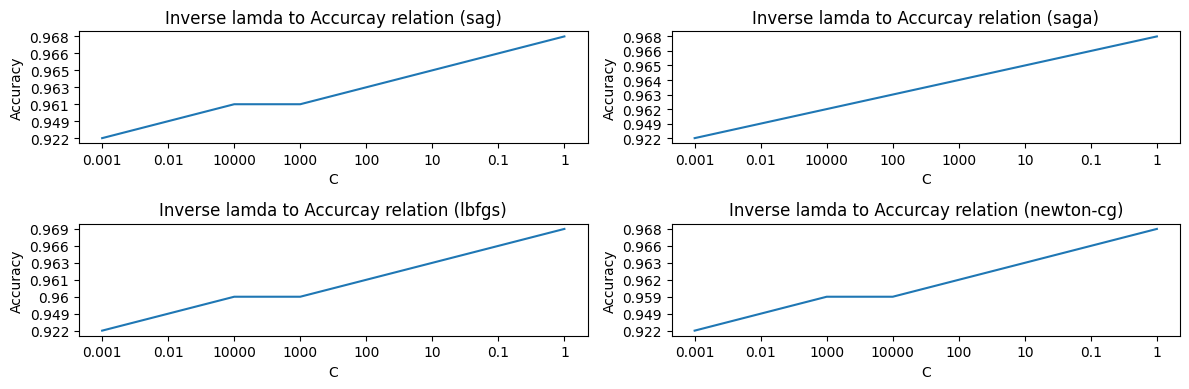

In [15]:
# Plotting relations between Inverse lamda and its effect on accuracy

params = params[params[:, 0].argsort()]
sag = params[params[:, 1] == 'sag']
saga = params[params[:, 1] == 'saga']
lbfgs = params[params[:, 1] == 'lbfgs']
newton_cg = params[params[:, 1] == 'newton-cg']

# top left plot
plt.figure(figsize=(12, 4))
plt.subplot(2, 2, 1)
plt.plot(sag[:, 2], sag[:, 0])
# plt.xscale('log')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title('Inverse lamda to Accurcay relation (sag)')

# top right plot
plt.subplot(2, 2, 2)
plt.plot(saga[:, 2], saga[:, 0])
# plt.xscale('log')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title('Inverse lamda to Accurcay relation (saga)')

# bot left plot
plt.subplot(2, 2, 3)
plt.plot(lbfgs[:, 2], lbfgs[:, 0])
# plt.xscale('log')

plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title('Inverse lamda to Accurcay relation (lbfgs)')

# bot right plot
plt.subplot(2, 2, 4)
plt.plot(newton_cg[:, 2], newton_cg[:, 0])
# plt.xscale('log')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title('Inverse lamda to Accurcay relation (newton-cg)')


plt.tight_layout()

plt.show()

From the Plots above we can conclude that:
Optimizers doesn't make much differences in our case
Inverse lamda(C) gives reasonable results from 0.1 to 10
and C=1 has the best performance
and also C=0.001 is the worst as explained above.

In [16]:
logistic_classifier = LogisticRegression(solver=best_solver, C=best_lamda_inverse)
logistic_classifier.fit(hog_X_train_descriptors, train_labels)
logistic_y_pred = logistic_classifier.predict(hog_X_test_descriptors)

logistic_accuracy = accuracy_score(test_labels, y_pred)
print(f'Highest Logistic Accuracy: {logistic_accuracy}')

Highest Logistic Accuracy: 0.9221428571428572


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Evaluation

In [17]:
from sklearn.metrics import confusion_matrix, f1_score
# create confusion matrix for each model
cm1 = confusion_matrix(test_labels, y_pred1)
cm2 = confusion_matrix(test_labels, y_pred2)
logistic_cm = confusion_matrix(test_labels, logistic_y_pred)
# calculate f1_score for each model
## f1_score is calculated for each label and then take unweighted mean
score1 = f1_score(test_labels, y_pred1, average='macro')
score2 = f1_score(test_labels, y_pred2, average='macro')
logistic_score = f1_score(test_labels, logistic_y_pred, average='macro')
print(f"f1_score of SVM: {score1}")
print(f"f1_score of KNN: {score2}")
print(f"f1_score of Logistic Regression: {logistic_score}")

f1_score of SVM: 0.9308974256442927
f1_score of KNN: 0.9447921790699623
f1_score of Logistic Regression: 0.9684379764374874
